# Evidencia 1 - Equipo 47

## Introducción

En este trabajo se realiza un análisis exploratorio y particionamiento de un conjunto de datos de mortalidad, considerando variables como grupo etario y causa de muerte. Se calcula la distribución de frecuencias, se genera un particionamiento del conjunto de datos, y se describen las técnicas de muestreo que permitirán obtener muestras representativas para análisis posteriores.


#Caracterización de variables

## Caracterización de la población

A continuación se presenta la tabla de caracterización de las variables del conjunto de datos, incluyendo su dominio, estadísticas conocidas u observadas, y comentarios adicionales.

| Variable    | Dominio / Valores posibles               | Estadísticas conocidas / Observadas                                      | Comentarios relevantes                                                        |
|-------------|-----------------------------------------|-------------------------------------------------------------------------|--------------------------------------------------------------------------------|
| edad       | 0–120 (derivada)                       | 58.7% ≥65 años (INEGI 2022)                                             | Crucial para segmentar causas y tasas de muerte.                              |
| sexo       | Masculino / Femenino                  | 56.2% hombres, 43.7% mujeres (INEGI 2022)                              | Disparidades en mortalidad y causas según sexo.                               |
| ent_resid  | 32 estados de México                  | CDMX y Edomex con más registros                                        | Útil para análisis regional y políticas focalizadas.                          |
| mun_resid  | ~2,400 municipios                     | Varía por densidad poblacional                                          | Permite análisis local y urbano/rural.                                        |
| anio_ocurr | 2012–2022                             | Pico en 2020 por COVID-19                                               | Indica tendencias a largo plazo.                                              |
| mes_ocurr  | 1–12                                  | Picos en invierno por causas respiratorias                              | Útil para detectar estacionalidad.                                            |
| causa_def  | CIE-10 (codificada)                  | Principales: corazón, diabetes, cáncer                                 | Base para todo análisis de salud pública.                                     |
| dayofyear  | 1–365                                | Estacionalidad observable                                              | Más granular que el mes.                                                     |
| daylength  | 10–14 hrs aprox. según estación      | Varía según latitud y fecha                                             | Potencial correlación con ritmos circadianos.                                |
| night      | True / False                         | -                                                                       | Permite diferenciar patrones de mortalidad día/noche.                         |


In [ ]:
# Montar drive de colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Generar sesión Spark
!pip install pyspark
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import col, round

spark = SparkSession.builder \
    .appName("Caracterizacion Mortalidad MX") \
    .getOrCreate()

In [ ]:
# Leer archivo base en formato Parquet
df_base = spark.read.parquet('/content/drive/My Drive/Proyecto_Big_Data/mxmortality_rev.parquet')
df_base.printSchema()
print("Total registros:", df_base.count())

root
 |-- decease_date: string (nullable = true)
 |-- birth_date: string (nullable = true)
 |-- decease_date_UTC: string (nullable = true)
 |-- decease_date_solar: string (nullable = true)
 |-- decease_date_comp: string (nullable = true)
 |-- tod: double (nullable = true)
 |-- daylength: double (nullable = true)
 |-- gdaylength: double (nullable = true)
 |-- flux: double (nullable = true)
 |-- gflux: double (nullable = true)
 |-- lat: double (nullable = true)
 |-- long: double (nullable = true)
 |-- night: boolean (nullable = true)
 |-- gr_lismex: string (nullable = true)
 |-- desc: string (nullable = true)
 |-- sexo: long (nullable = true)
 |-- causa_def: string (nullable = true)
 |-- Br: double (nullable = true)
 |-- Bt: double (nullable = true)
 |-- Bp: double (nullable = true)
 |-- gBr: double (nullable = true)
 |-- gBt: double (nullable = true)
 |-- gBp: double (nullable = true)

Total registros: 7578742


In [ ]:
# Filtrar filas con decease_date > 2022 o < 2012
df_outliers = df_base.filter((F.year("decease_date") > 2022) | (F.year("decease_date") < 2012))
print("Filas con decease_date fuera del rango 2012-2022:")
df_outliers.show()

Filas con decease_date fuera del rango 2012-2022:
+------------+----------+-------------------+--------------------+-------------------+------------------+------------------+-------------------+---------+----------+------------------+-------------------+-----+---------+--------------------+----+---------+-------------------+-------------------+------------------+-------------------+------------------+------------------+
|decease_date|birth_date|   decease_date_UTC|  decease_date_solar|  decease_date_comp|               tod|         daylength|         gdaylength|     flux|     gflux|               lat|               long|night|gr_lismex|                desc|sexo|causa_def|                 Br|                 Bt|                Bp|                gBr|               gBt|               gBp|
+------------+----------+-------------------+--------------------+-------------------+------------------+------------------+-------------------+---------+----------+------------------+------------------

In [ ]:
# Filtrar dataset para remover outliers
df_base = df_base.filter((F.year("decease_date") >= 2012) & (F.year("decease_date") <= 2022))

In [ ]:
# Variables derivadas: edad, grupo de edad (nuevos binarios), año, mes, día
df_feat = df_base \
    .withColumn("age", F.floor(F.datediff("decease_date", "birth_date")/365.25)) \
    .withColumn("year", F.year("decease_date")) \
    .withColumn("month", F.month("decease_date")) \
    .withColumn("day", F.dayofmonth("decease_date")) \
    .withColumn("age_grp",
        F.when(F.col("age") < 5, "0-4")
         .when((F.col("age") >= 5) & (F.col("age") <= 14), "5-14")
         .when((F.col("age") >= 15) & (F.col("age") <= 24), "15-24")
         .when((F.col("age") >= 25) & (F.col("age") <= 44), "25-44")
         .when((F.col("age") >= 45) & (F.col("age") <= 64), "45-64")
         .otherwise("65+")
    )
df_feat.select("age","age_grp","year","month","sexo").show(5)

+---+-------+----+-----+----+
|age|age_grp|year|month|sexo|
+---+-------+----+-----+----+
| 70|    65+|2012|    3|   2|
| 77|    65+|2012|    4|   2|
| 82|    65+|2012|    4|   1|
|100|    65+|2012|    6|   2|
| 72|    65+|2012|    6|   1|
+---+-------+----+-----+----+
only showing top 5 rows



In [ ]:
# Distribución por grupo de edades
total = df_feat.count()
dist_age = df_feat.groupBy("age_grp") \
    .agg(F.count("*").alias("n")) \
    .withColumn("pct", F.round(F.col("n")/F.lit(total)*100,2)) \
    .orderBy("age_grp")
dist_age.show(truncate=False)

+-------+-------+-----+
|age_grp|n      |pct  |
+-------+-------+-----+
|0-4    |279208 |3.69 |
|15-24  |209111 |2.76 |
|25-44  |763730 |10.1 |
|45-64  |1903214|25.16|
|5-14   |54351  |0.72 |
|65+    |4353957|57.56|
+-------+-------+-----+



In [ ]:
# Distribución por sexo
dist_sex = df_feat.groupBy("sexo") \
    .agg(F.count("*").alias("n")) \
    .withColumn("pct", F.round(F.col("n")/F.lit(total)*100,2)) \
    .orderBy("sexo")
dist_sex.show()

+----+-------+-----+
|sexo|      n|  pct|
+----+-------+-----+
|   1|4233830|55.98|
|   2|3329741|44.02|
+----+-------+-----+



In [ ]:
# Top 20 entidades de residencia (si existe 'ent_resid')
if "ent_resid" in df_feat.columns:
    dist_ent = df_feat.groupBy("ent_resid") \
        .agg(F.count("*").alias("n")) \
        .orderBy(F.desc("n")) \
        .limit(20)
    dist_ent.show(truncate=False)

In [ ]:
# Top 20 causas de muerte
top_cause = df_feat.groupBy("desc") \
    .agg(F.count("*").alias("n")) \
    .orderBy(F.desc("n")) \
    .limit(20)
top_cause.show(truncate=False)

+-------------------------------------------------------------------------------------------------------------+-------+
|desc                                                                                                         |n      |
+-------------------------------------------------------------------------------------------------------------+-------+
|Enfermedades endocrinas y metabólicas                                                                        |1192021|
|Enfermedades isquémicas del corazón                                                                          |1138083|
|Enfermedades de otras partes del aparato digestivo                                                           |663559 |
|Otras enfermedades del aparato respiratorio                                                                  |650011 |
|Enfermedades víricas                                                                                         |536645 |
|Enfermedades cerebrovasculares         

In [ ]:
# Serie temporal: anual y mensual
ts_year = df_feat.groupBy("year") \
    .agg(F.count("*").alias("deaths")) \
    .orderBy("year")
ts_month = df_feat.groupBy("year","month") \
    .agg(F.count("*").alias("deaths")) \
    .orderBy("year","month")

ts_year.show()
ts_month.show(12)

+----+-------+
|year| deaths|
+----+-------+
|2012| 299459|
|2013| 309725|
|2014| 604628|
|2015| 636627|
|2016| 666763|
|2017| 681012|
|2018| 691634|
|2019| 719687|
|2020|1064215|
|2021|1090968|
|2022| 798853|
+----+-------+

+----+-----+------+
|year|month|deaths|
+----+-----+------+
|2012|    1|  3677|
|2012|    2|  7637|
|2012|    3| 11185|
|2012|    4| 14215|
|2012|    5| 18690|
|2012|    6| 21345|
|2012|    7| 25964|
|2012|    8| 30113|
|2012|    9| 32991|
|2012|   10| 38018|
|2012|   11| 43147|
|2012|   12| 52477|
+----+-----+------+
only showing top 12 rows



In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Correlación de variables ambientales
env_vars = ["flux","gflux","daylength","gdaylength","Br","Bt","Bp"]

In [ ]:
# Correlación de variables ambientales
env_sample = ( df_feat
    .select(env_vars)
    .na.drop()
    .sample(False, 0.005, seed=1)
    .limit(20000)
)
env_pd = env_sample.toPandas()
corr_env = env_pd.corr()
print(corr_env)

                flux     gflux  daylength  gdaylength        Br        Bt  \
flux        1.000000 -0.019758  -0.024668    0.005981 -0.003716  0.023943   
gflux      -0.019758  1.000000   0.013827    0.001753  0.015565  0.005965   
daylength  -0.024668  0.013827   1.000000    0.002622  0.008667 -0.016848   
gdaylength  0.005981  0.001753   0.002622    1.000000  0.001102 -0.000686   
Br         -0.003716  0.015565   0.008667    0.001102  1.000000 -0.203641   
Bt          0.023943  0.005965  -0.016848   -0.000686 -0.203641  1.000000   
Bp         -0.022979 -0.010155   0.015800   -0.001626  0.148332 -0.914907   

                  Bp  
flux       -0.022979  
gflux      -0.010155  
daylength   0.015800  
gdaylength -0.001626  
Br          0.148332  
Bt         -0.914907  
Bp          1.000000  


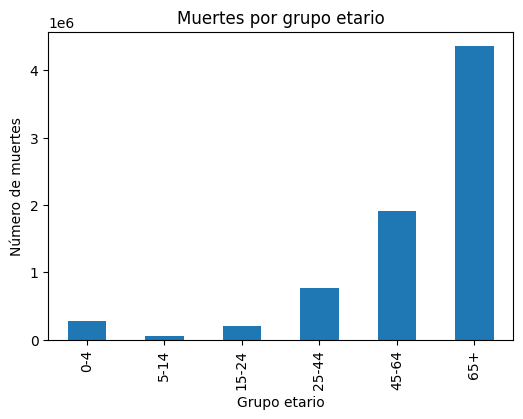

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Convertimos a Pandas y establecemos 'age_grp' como índice
df_age = dist_age.toPandas().set_index("age_grp")

# Definimos el orden correcto de los grupos etarios
age_order = ['0-4', '5-14', '15-24', '25-44', '45-64', '65+']

# Convertimos el índice a categoría ordenada usando el orden correcto
df_age.index = pd.Categorical(df_age.index, categories=age_order, ordered=True)

# Ordenamos el DataFrame por índice (orden natural de edad)
df_age = df_age.sort_index()

# Distribución por edad
df_age["n"].plot(kind="bar", figsize=(6,4), title="Muertes por grupo etario")
plt.ylabel("Número de muertes")
plt.xlabel("Grupo etario")
plt.show()

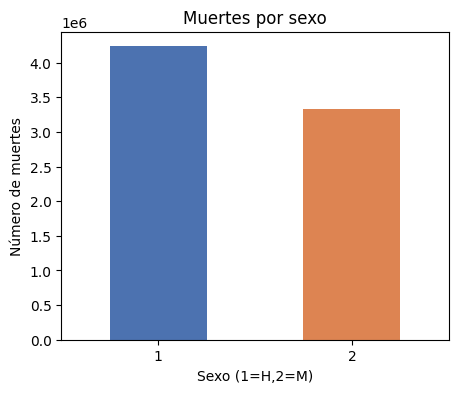

In [ ]:
# Distribución por sexo (2 barras)
df_sex = dist_sex.toPandas().set_index("sexo")
df_sex["n"].plot(kind="bar", color=["#4c72b0","#dd8452"], figsize=(5,4),
                  title="Muertes por sexo")
plt.xticks(rotation=0)
plt.ylabel("Número de muertes")
plt.xlabel("Sexo (1=H,2=M)")
plt.show()

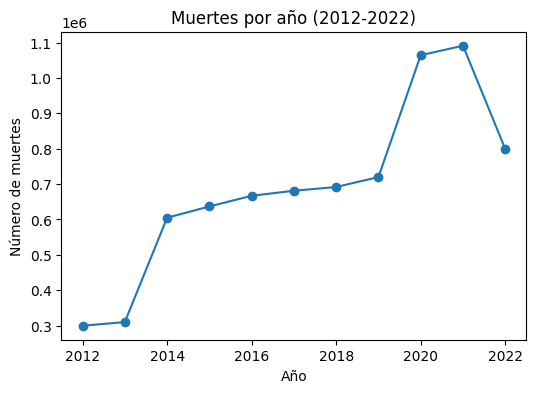

In [ ]:
# Serie anual
df_year = ts_year.toPandas().set_index("year")
df_year["deaths"].plot(marker="o", figsize=(6,4), title="Muertes por año (2012-2022)")
plt.ylabel("Número de muertes")
plt.xlabel("Año")
plt.show()

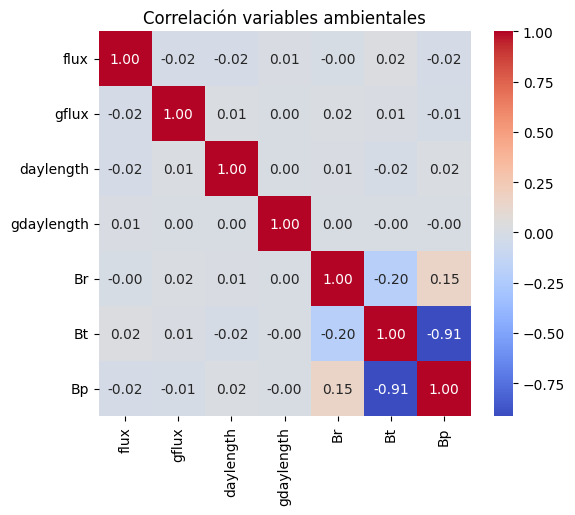

In [ ]:
# Heatmap de correlación ambiental
plt.figure(figsize=(6,5))
sns.heatmap(corr_env, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlación variables ambientales")
plt.show()

## Particionamiento

Se utiliza el particionamiento por combinación de grupo etario (`age_grp`) y causa de muerte (`desc`).  
Se calculan las frecuencias de cada combinación y la probabilidad de ocurrencia relativa al total de datos.  
Esto permite segmentar el conjunto de datos en grupos homogéneos para análisis posteriores.


In [ ]:
# Calculamos el total de registros
total_count = df_feat.count()

# Agrupamos por age_grp y desc, calculamos conteo y probabilidad
comb_stats = (
    df_feat
    .groupBy("age_grp", "desc")
    .count()
    .withColumn("prob", round(col("count") / F.lit(total_count), 4))
)

# Mostramos las combinaciones más frecuentes
comb_stats.orderBy(col("count").desc()).show(20, truncate=False)

+-------+-----------------------------------------------------------------------------------------------+------+------+
|age_grp|desc                                                                                           |count |prob  |
+-------+-----------------------------------------------------------------------------------------------+------+------+
|65+    |Enfermedades isquémicas del corazón                                                            |875552|0.1158|
|65+    |Enfermedades endocrinas y metabólicas                                                          |730832|0.0966|
|65+    |Otras enfermedades del aparato respiratorio                                                    |472124|0.0624|
|45-64  |Enfermedades endocrinas y metabólicas                                                          |393163|0.052 |
|65+    |Enfermedades de otras partes del aparato digestivo                                             |335136|0.0443|
|65+    |Enfermedades cerebrovasculares 

## Descripción detallada del proceso de muestreo

Para recuperar instancias de cada partición generada, se utilizará un proceso de muestreo aleatorio estratificado.

### Técnica de muestreo propuesta:
Se seleccionará un número fijo de muestras por cada combinación (`age_grp`, `desc`) utilizando la función `.sample()` de PySpark, especificando la fracción deseada de muestreo, o `.limit()` si queremos extraer un número exacto de registros.

### Justificación:
El muestreo estratificado es adecuado porque garantiza que todas las combinaciones relevantes de grupo etario y causa de muerte estén representadas proporcionalmente en el conjunto de muestras. Esto es importante porque muchas causas son raras en ciertos grupos etarios, y un muestreo aleatorio simple podría no capturarlas adecuadamente.

### Ejemplo de código:
```python
# Ejemplo: extraer 0.1% de cada partición
sampled_partitions = {}
for key, df_part in partitions.items():
    sampled_df = df_part.sample(fraction=0.001, seed=42)
    sampled_partitions[key] = sampled_df


In [ ]:
# Validar el particionamiento con las 5 más frecuentes:
top5 = comb_stats.orderBy(col("count").desc()).limit(5).collect()
for row in top5:
    grp, causa = row["age_grp"], row["desc"]
    print(f"\nEjemplo de partición: edad={grp}  → causa='{causa}' (n={row['count']}, prob={row['prob']})")
    # Mostrar 3 registros de prueba de esa partición
    df_feat \
      .filter((col("age_grp") == grp) & (col("desc") == causa)) \
      .show(3, truncate=False)


Ejemplo de partición: edad=65+  → causa='Enfermedades isquémicas del corazón' (n=875552, prob=0.1158)
+------------+----------+-------------------+--------------------------+-------------------+----+------------------+-------------------+---------+----------+-----------------+-------------------+-----+---------+-----------------------------------+----+---------+-------------------+------------------+------------------+-------------------+------------------+------------------+---+----+-----+---+-------+
|decease_date|birth_date|decease_date_UTC   |decease_date_solar        |decease_date_comp  |tod |daylength         |gdaylength         |flux     |gflux     |lat              |long               |night|gr_lismex|desc                               |sexo|causa_def|Br                 |Bt                |Bp                |gBr                |gBt               |gBp               |age|year|month|day|age_grp|
+------------+----------+-------------------+--------------------------+-------------

In [ ]:
# 4. Validar el particionamiento con las 5 menos frecuentes:

comb_stats.orderBy(col("count").asc()).show(20, truncate=False)

bottom5 = comb_stats.orderBy(col("count").asc()).limit(5).collect()
for row in bottom5:
    grp, causa = row["age_grp"], row["desc"]
    print(f"\nEjemplo de partición: edad={grp}  → causa='{causa}' (n={row['count']}, prob={row['prob']})")
    df_feat \
      .filter((col("age_grp") == grp) & (col("desc") == causa)) \
      .show(3, truncate=False)


Ejemplo de partición: edad=45-64  → causa='Ciertas afecciones originadas en el periodo perinatal' (n=1, prob=0.0)
+------------+----------+-------------------+--------------------------+-------------------+---+------------------+-----------------+--------+----------+-----------------+-----------------+-----+---------+-----------------------------------------------------+----+---------+-----------------+-------------------+------------------+-------------------+------------------+-----------------+---+----+-----+---+-------+
|decease_date|birth_date|decease_date_UTC   |decease_date_solar        |decease_date_comp  |tod|daylength         |gdaylength       |flux    |gflux     |lat              |long             |night|gr_lismex|desc                                                 |sexo|causa_def|Br               |Bt                 |Bp                |gBr                |gBt               |gBp              |age|year|month|day|age_grp|
+------------+----------+-------------------+--------

### Observación del particionamiento

Notamos que existen varios grupos que no cuentan con 3 registros. Esto limita la capacidad de muestrear sin reemplazo, ya que no habría suficientes datos para representar adecuadamente esos estratos. Para evitar excluirlos o introducir sesgos, decidimos aplicar la siguiente lógica de muestreo:

* Para estratos con al menos 10 registros: se aplica muestreo estratificado proporcional sin reemplazo, manteniendo las proporciones originales.

* Para estratos con menos de 10 registros: se aplica muestreo con reemplazo hasta alcanzar un tamaño mínimo de 5 instancias, permitiendo que esos grupos minoritarios estén representados en el conjunto final.

Esta estrategia equilibra representatividad y cobertura, asegurando que ningún grupo quede fuera del análisis y reduciendo el sesgo muestral.

In [ ]:
min_n = 5
fraction = 0.1  # ejemplo de fracción (10%) para estratos grandes

samples = []
for row in comb_stats.collect():
    grp, causa, cnt = row["age_grp"], row["desc"], row["count"]
    df_part = df_feat.filter((col("age_grp")==grp)&(col("desc")==causa))
    if cnt < min_n:
        samp = df_part.sample(withReplacement=True, fraction=min_n/cnt) # con reemplazo, tomamos exactamente min_n (puede repetir)
    else:
        samp = df_part.sample(withReplacement=False, fraction=fraction) # sin reemplazo, muestreo proporcional
    samples.append(samp)


In [ ]:
final_sample = samples[0]
for samp in samples[1:]:
    final_sample = final_sample.unionByName(samp)

In [ ]:
final_sample

## Drive de consulta notebook

Todos los resultados y el notebook han sido guardados en Google Drive para su consulta y descarga.  
A continuación se proporciona el enlace de acceso compartido:

[https://colab.research.google.com/drive/1DGBaLB9VZLyKQXeJaXtfrdKH_yYIsFfu#scrollTo=3znoNxPAWtih](https://colab.research.google.com/drive/1DGBaLB9VZLyKQXeJaXtfrdKH_yYIsFfu#scrollTo=3znoNxPAWtih)
